Greetings!
I've decided to use Colab not only to run my SQL scripts and visualize data with Matplotlib but also to document and explain my thought process.



---



After understanding the challenge, my first step was to standardize the data using Excel. This way, when I upload the CSV, the data would adhere to a consistent format.

The standardization process involved converting three columns, **status_change_date, lead_created_date, and current_opp_status_date**, from the INT type to DATETIME, aligning them with the **current_lead_status_date** column.


 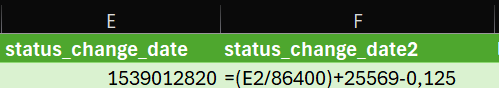

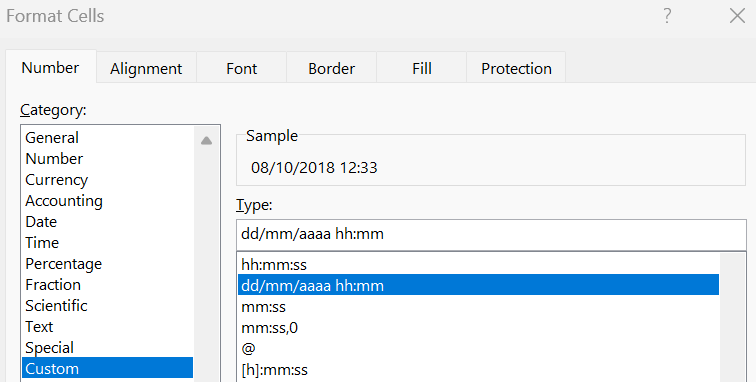

moving on to the actual challenge,
first I had to import the libraries, I am more used to work with SAP Hana for SQL Scripts or Oracle.

So I made some researches on how to connect it straight to Google Colab.





In [ ]:
import pandas as pd
import sqlite3

In [ ]:
df = pd.read_csv('sales_data_standard.csv')

In [ ]:
conn = sqlite3.connect('sales_data.db')

In [ ]:
df.to_sql('sales_data', conn, if_exists='replace', index=False)

5656

In [ ]:
pd.read_sql('SELECT * FROM sales_data LIMIT 5', conn)

,company,opportunity_value,old_status_label,new_status_label,status_change_date,lead_created_date,current_lead_status,current_lead_status_date,current_opp_status,current_opp_status_date,billing_period_unit,billing_period
0,company11,29,MR - Qualification,AE - Qualified,2018-10-08 15:33:40,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,1
1,company11,29,AE - Qualified,AE - Negotiation,2018-10-08 15:59:09,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,1
2,company11,29,AE - Negotiation,Confirmed,2018-10-10 14:47:37,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,1
3,company11,29,Confirmed,Paying,2018-10-18 12:25:32,2018-10-08 11:47:55,Customer,2018-10-10 14:47:41,Paying,2018-10-18 12:25:32,month,3
4,company15,272,MR - Qualification,AE - Qualified,2019-04-03 12:59:46,2019-04-01 09:54:41,Qualified,2019-04-03 12:57:49,AE - Qualified,2019-04-03 12:59:46,year,1


After the scripts above, I was able to get started with the first part of the challenge:
 * Create a sqlite database in the same directory
 * Load the data to the database




---



ANSWERING THE QUESTIONS

# Calculate the average time per company to become a customer

My thought process when answering the first question was to first understand the dates in the dataset.

Since I had already standardized the data, it was easier to write the query and get accurate results.

There are four different dates in the dataset:
status_change_date, lead_created_date, current_lead_status_date, and current_opp_status_date.

By analyzing each one, I understood the following:

**lead_created_date** refers to when the lead is initially created.

**status_change_date** marks when the status changes after the lead is created.

**current_lead_status_date** is an update of the status after the previous change.

**current_opp_status_date** is the final date that reflects the current opportunity status.

After that, I also understood that I should filter **current_opp_status** as "Paying", since it indicates the leads that actually became customers.


In [ ]:
query = """
SELECT
    AVG(JULIANDAY(current_opp_status_date) - JULIANDAY(lead_created_date)) AS avg_days_to_customer
FROM (
    SELECT
        company,
        MIN(lead_created_date) AS lead_created_date,
        MAX(current_opp_status_date) AS current_opp_status_date
    FROM sales_data
    WHERE current_opp_status = 'Paying'
    GROUP BY company
);
"""

In [ ]:
result = pd.read_sql_query(query, conn)
print(result)

   avg_days_to_customer
0             78.644105




---



## Calculate how many customers have churned and reactivated:
Bellow you will see the query for the challenge.

My thought process was very simple and focused mostly on understanding two things:
 * Whats the current_opp_status?
 * Whats the current_lead_status?

 Because if I focused ONLY on the current_opp_status, which has "Churned" as one of the values in the column, the results would be completely different from the one I got, because we would have differents status on differents columns.

 After analyzing the data set I understood it makes sense to use current_lead_status as a filter as well because we could get ONLY the actual customers and not just any potential clients

In [ ]:
query2 = """
SELECT COUNT(DISTINCT company) AS churned_and_reactivated
FROM (
    SELECT company
    FROM sales_data
    WHERE current_opp_status = 'Churned'
    AND current_lead_status = 'Customer'
) AS churns
WHERE company IN (
    SELECT company FROM sales_data
    WHERE 'current_opp_status' != 'Churned'
    AND current_lead_status = 'Customer'
)
"""


In [ ]:
pd.read_sql(query2, conn)

,churned_and_reactivated
0,1




---



## Calculate the expected MRR (monthly recurring revenue) per month

To calculate the monthly revenue, I had to take into account the following columns:

**billing_period_unit**: indicates the billing type, whether it's monthly or yearly. (Since we want the value in months, any yearly billing should be converted.)

**billing_period**: tells us the duration of the billing cycle, in months or years.

**current_opp_status**: should be filtered as "Paying", since it represents active and most importantly paying customers.

In [ ]:
query = """
SELECT
  strftime('%Y-%m', current_opp_status_date) AS month,
  SUM(opportunity_value * 1.0 /
      CASE
        WHEN LOWER(billing_period_unit) = 'year' THEN billing_period * 12
        WHEN LOWER(billing_period_unit) = 'month' THEN billing_period
        ELSE 1
      END
  ) AS expected_mrr
FROM sales_data
WHERE LOWER(current_opp_status) = 'paying'
GROUP BY month
ORDER BY month;
"""

In [ ]:
mrr_df = pd.read_sql_query(query, conn)
print(mrr_df)

      month  expected_mrr
0   2016-06    507.821609
1   2016-07     29.750000
2   2016-08     48.035714
3   2016-09     48.009524
4   2016-10     59.083333
5   2016-11    192.189286
6   2016-12    130.050000
7   2017-01   1711.145418
8   2017-02    545.394444
9   2017-03    758.544444
10  2017-04    280.633838
11  2017-05    999.399892
12  2017-06    562.327345
13  2017-07    683.433153
14  2017-08    418.778211
15  2017-09    447.459524
16  2017-10    669.248232
17  2017-11   1040.694048
18  2017-12    628.406349
19  2018-01    939.779582
20  2018-02    871.683333
21  2018-03    833.989141
22  2018-04   1225.671825
23  2018-05    743.483333
24  2018-06   1065.543218
25  2018-07    845.653463
26  2018-08   1126.053932
27  2018-09   1042.641486
28  2018-10   1535.196104
29  2018-11   1248.287662
30  2018-12   1497.133261
31  2019-01   2412.053824
32  2019-02   1543.271681
33  2019-03    949.547258
34  2019-04     34.333333
35  2019-05    189.833333




---



## Calculate the number of (potential) customers per month up to today
My idea here was to check all possible statuses. I could've just looked at the current_lead_status and current_opp_status. but my idea was to filter removing all the status who were lost, churned, potential fake, not interested, blacklist, not responding, cold... because that way i could truly focus on potential clients and i also aligned all of them to avoid a mx of negative and positive indicators


In [ ]:
query = """
SELECT
  strftime('%Y-%m', current_opp_status_date) AS month,
  COUNT(DISTINCT company) AS potential_customers
FROM sales_data
WHERE
  LOWER(old_status_label) NOT IN ('opp - lost', 'churned')
  AND LOWER(new_status_label) NOT IN ('opp - lost', 'churned')
  AND LOWER(current_lead_status) NOT IN ('lost', 'cold', 'potential fake', 'not interested', 'blacklist', 'not responding')
  AND LOWER(current_opp_status) NOT IN ('opp - lost', 'churned')
GROUP BY month
ORDER BY month;
"""


In [ ]:
pd.read_sql_query(query, conn)

,month,potential_customers
0,2016-06,31
1,2016-07,3
2,2016-08,3
3,2016-09,4
4,2016-10,3
5,2016-11,6
6,2016-12,16
7,2017-01,82
8,2017-02,18
9,2017-03,35




---



Now moving to the last part of the challenge, loading the tables from the sqlite db to pandas dataframes

# Create charts/analyses that you believe show some business value.  Some graphing libraries you can use are Matplotlib or Seaborn, but please use whatever you are comfortable with.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns

# My analysis:

First i focused on visualizing the companies with highest revenue.
For that, i considered the opportunity value and the billing periods.

First, I looked up on how to normalize the periods, so if we had on the data set column billing_period_unit as "year" I would convert it to months.

Then calculate the total revenue considering the opportunity value and the period in months

And after that group by company, limiting by top 10

In [ ]:
df['period_in_months'] = df.apply(
    lambda row: row['billing_period'] * 12 if row['billing_period_unit'].lower() == 'year' else row['billing_period'],
    axis=1
)

In [ ]:
df['total_revenue'] = df['opportunity_value'] * df['period_in_months']

In [ ]:
revenue_by_company = df.groupby('company')['total_revenue'].sum().sort_values(ascending=False).reset_index()
top_10_companies = revenue_by_company.head(10)

<ipython-input-25-23426b08b632>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_companies, x='total_revenue', y='company', palette='Blues_r')


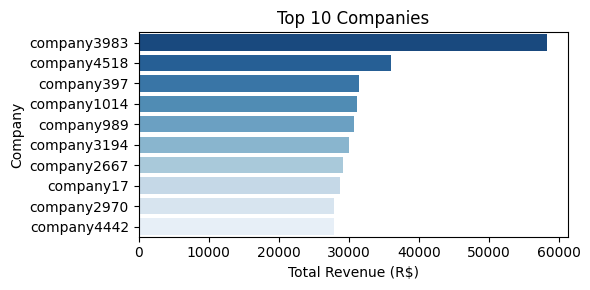

In [ ]:
plt.figure(figsize=(6, 3))
sns.barplot(data=top_10_companies, x='total_revenue', y='company', palette='Blues_r')
plt.title('Top 10 Companies')
plt.xlabel('Total Revenue (R$)')
plt.ylabel('Company')
plt.tight_layout()
plt.show()

There are many insights and analysis we could do, such as:

* Compare contracts long and short term
* Create a storytelling about the number one client, if it's a food company, for example, how we could attract more clients from the same segment, focus on advertisement.




---



# What predictive score could you build here to show business value? Explain/Demonstrate your answer.

One predictive score that could add real business value is a Lead Conversion Probability Score.
Using data like lead creation date, historical status changes, opportunity value, and billing patterns, we could train a model to estimate the likelihood that a lead will become a paying customer.

This score would allow the sales team to prioritize high-potential leads, improve efficiency, and ultimately increase revenue.

AUC: 0.70


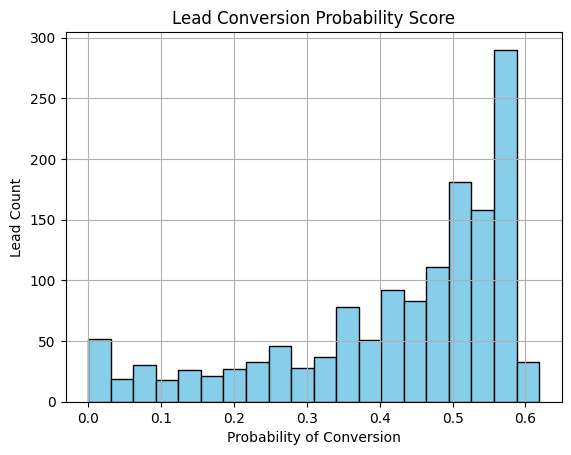

In [ ]:
# creating the target
df['converted'] = df['current_opp_status'].str.lower() == 'paying'

# features
df['billing_period'] = pd.to_numeric(df['billing_period'], errors='coerce')
df['opportunity_value'] = pd.to_numeric(df['opportunity_value'], errors='coerce')

# drop values
df_model = df[['billing_period', 'opportunity_value', 'converted']].dropna()

# variables
X = df_model[['billing_period', 'opportunity_value']]
y = df_model['converted'].astype(int)

# train model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

# probability
y_probs = model.predict_proba(X_test)[:, 1]

# AUC
auc = roc_auc_score(y_test, y_probs)
print(f"AUC: {auc:.2f}")

# PLOT
plt.hist(y_probs, bins=20, color='skyblue', edgecolor='black')
plt.title('Lead Conversion Probability Score')
plt.xlabel('Probability of Conversion')
plt.ylabel('Lead Count')
plt.grid(True)
plt.show()